# Run meta-analyses on 21 pain studies
Collection of NIDM-Results packs downloaded from Neurovault collection [1425](https://www.neurovault.org/collections/1425/), uploaded by Dr. Camille Maumet.

In [10]:
%matplotlib inline
import json
import numpy as np
from glob import glob
import os.path as op

import pandas as pd
import nibabel as nib
from scipy.stats import t
from nilearn.masking import apply_mask
from nilearn.plotting import plot_stat_map

import nimare
from nimare.utils import get_resource_path
from nimare.meta.ibma import (stouffers, fishers, weighted_stouffers,
                              rfx_glm, ffx_glm)

from nidm_utils import get_files

In [11]:
dset_file = op.join(get_resource_path(),
                    'data/nidm_pain_dset_with_subpeaks.json')
with open(dset_file, 'r') as fo:
    dset_dict = json.load(fo)
db = nimare.dataset.Database(dset_file)
dset = db.get_dataset()

mask_img = dset.mask

logp_thresh = -np.log(.05)

## Get z-maps

In [12]:
# Regular z maps
z_files = get_files(dset_dict, ['z'])
z_imgs = [nib.load(f) for f in z_files[0]]
z_data = apply_mask(z_imgs, mask_img)

# T maps to be converted to z
t_files, t_ns = get_files(dset_dict, ['t!z', 'n'])
t_imgs = [nib.load(f) for f in t_files]
t_data_list = [apply_mask(t_img, mask_img) for t_img in t_imgs]
tz_data_list = [nimare.utils.t_to_z(t_data, t_ns[i]-1) for i, t_data
                in enumerate(t_data_list)]
tz_data = np.vstack(tz_data_list)

# Combine
z_data = np.vstack((z_data, tz_data))

print('{0} studies found.'.format(z_data.shape[0]))

21 studies found.


## Fisher's

CPU times: user 1.24 s, sys: 327 ms, total: 1.57 s
Wall time: 1.64 s


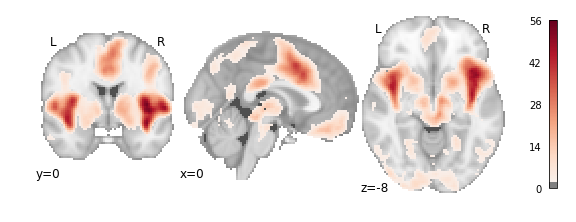

In [13]:
%%time
result = fishers(z_data, mask_img)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

## Stouffer's

### Fixed-effects inference

In [ ]:
%%time
result = stouffers(z_data, mask_img, inference='ffx',
                   null='theoretical', n_iters=None)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

### Random-effects inference with theoretical null distribution

In [ ]:
%%time
result = stouffers(z_data, mask_img, inference='rfx',
                   null='theoretical', n_iters=None)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

### Random-effects inference with empirical null distribution

In [ ]:
%%time
result = stouffers(z_data, mask_img, inference='rfx',
                   null='empirical', n_iters=1000)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

## Get z-maps + sample sizes

In [ ]:
# Regular z maps
z_files, ns = get_files(dset_dict, ['z', 'n'])
z_imgs = [nib.load(f) for f in z_files]
z_data = apply_mask(z_imgs, mask_img)

# T maps to be converted to z
t_files, t_ns = get_files(dset_dict, ['t!z', 'n'])
t_imgs = [nib.load(f) for f in t_files]
t_data_list = [apply_mask(t_img, mask_img) for t_img in t_imgs]
tz_data_list = [nimare.utils.t_to_z(t_data, t_ns[i]-1) for i, t_data
                in enumerate(t_data_list)]
tz_data = np.vstack(tz_data_list)

# Combine
z_data = np.vstack((z_data, tz_data))
ns = np.concatenate((ns, t_ns))
sample_sizes = np.array(ns)

print('{0} studies found.'.format(z_data.shape[0]))

## Weighted Stouffer's

In [ ]:
%%time
result = weighted_stouffers(z_data, sample_sizes, mask_img)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

## Get contrast maps + contrast standard error maps + sample sizes

In [ ]:
con_files, se_files, ns = get_files(dset_dict, ['con', 'se', 'n'])
con_imgs = [nib.load(f) for f in con_files]
se_imgs = [nib.load(f) for f in se_files]
con_data = apply_mask(con_imgs, mask_img)
se_data = apply_mask(se_imgs, mask_img)
sample_sizes = np.array(ns)
print('{0} studies found.'.format(con_data.shape[0]))

## FFX GLM

In [ ]:
%%time
result = ffx_glm(con_data, se_data, sample_sizes, mask_img, equal_var=True)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

## Get contrast maps

In [ ]:
con_files = get_files(dset_dict, ['con'])
con_files = con_files[0]
con_imgs = [nib.load(f) for f in con_files]
con_data = apply_mask(con_imgs, mask_img)
print('{0} studies found.'.format(con_data.shape[0]))

## RFX GLM

### Theoretical null distribution

In [ ]:
%%time
result = rfx_glm(con_data, mask_img, null='theoretical', n_iters=None)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

### Empirical null distribution

In [ ]:
%%time
result = rfx_glm(con_data, mask_img, null='empirical', n_iters=1000)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

## MKDA

### Density analysis

In [ ]:
%%time
mkda = nimare.meta.cbma.MKDADensity(dset, ids=dset.ids, kernel__r=10)
mkda.fit(n_iters=10)
plot_stat_map(mkda.results.images['vfwe'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

### Chi2 with FDR correction

In [ ]:
%%time
mkda2 = nimare.meta.cbma.MKDAChi2(dset, ids=dset.ids, ids2=dset.ids, kernel__r=10)
mkda2.fit(corr='FDR')
plot_stat_map(mkda2.results.images['pAgF_z_FDR_05'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

### Chi2 with FWE correction

In [ ]:
%%time
mkda3 = nimare.meta.cbma.MKDAChi2(dset, ids=dset.ids, ids2=dset.ids, kernel__r=10)
mkda3.fit(corr='FWE', n_iters=10)
plot_stat_map(mkda3.results.images['pAgF_z_FWE_05'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## KDA

In [ ]:
%%time
kda = nimare.meta.cbma.KDA(dset, ids=dset.ids, kernel__r=10)
kda.fit(n_iters=10)
plot_stat_map(kda.results.images['vfwe'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## ALE

In [ ]:
%%time
ale = nimare.meta.cbma.ALE(dset, ids=dset.ids)
ale.fit(n_iters=10)
plot_stat_map(ale.results.images['vfwe'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## SCALE

In [ ]:
%%time
ijk = np.vstack(np.where(dset.mask.get_data())).T
scale = nimare.meta.cbma.SCALE(dset, ids=dset.ids, ijk=ijk)
scale.fit(n_iters=10)
plot_stat_map(scale.results.images['vthresh'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')